In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES']='0,1,2'

In [3]:
import pandas as pd
import numpy as np
bins_train = abs(pd.read_csv('/srv/scratch/jjwang01/proseq/bins_train.csv.gz', compression='gzip', index_col=0))
bins_val = abs(pd.read_csv('/srv/scratch/jjwang01/proseq/bins_val.csv.gz', compression='gzip', index_col=0))
bins_test = abs(pd.read_csv('/srv/scratch/jjwang01/proseq/bins_test.csv.gz', compression='gzip', index_col=0))

/users/jjwang01/.conda/envs/proseq/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log2
  import sys


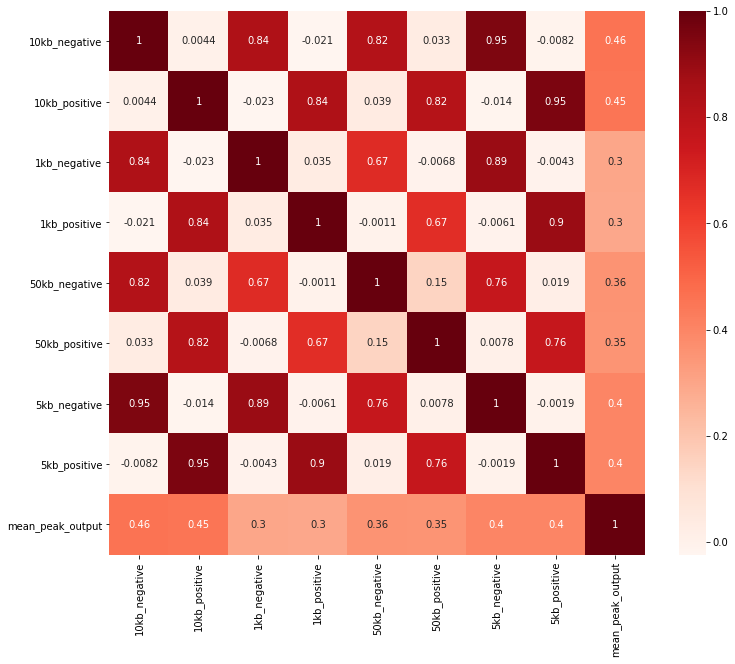

In [4]:
# Pearson correlation as sanity check
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
cor = np.log2(bins_train).corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

/users/jjwang01/.conda/envs/proseq/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.
/users/jjwang01/.conda/envs/proseq/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log2
  after removing the cwd from sys.path.


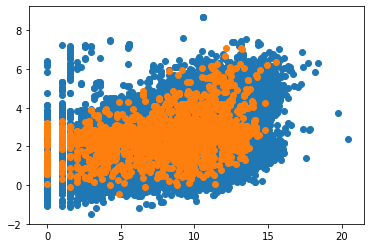

In [5]:
plt.scatter(np.log2(bins_train['10kb_positive'].values), np.log2(bins_train['mean_peak_output'].values))
#plt.show()

plt.scatter(np.log2(bins_val['10kb_negative'].values), np.log2(bins_val['mean_peak_output'].values))
plt.show()

In [6]:
bins_train = np.log2(bins_train)
bins_val = np.log2(bins_val)
bins_test = np.log2(bins_test)

# convert to back to negative values
bins_train['1kb_negative'] = -1 * bins_train['1kb_negative']
bins_train['5kb_negative'] = -1 * bins_train['5kb_negative']
bins_train['10kb_negative'] = -1 * bins_train['10kb_negative']
bins_train['50kb_negative'] = -1 * bins_train['50kb_negative']

bins_val['1kb_negative'] = -1 * bins_val['1kb_negative']
bins_val['5kb_negative'] = -1 * bins_val['5kb_negative']
bins_val['10kb_negative'] = -1 * bins_val['10kb_negative']
bins_val['50kb_negative'] = -1 * bins_val['50kb_negative']

bins_test['1kb_negative'] = -1 * bins_test['1kb_negative']
bins_test['5kb_negative'] = -1 * bins_test['5kb_negative']
bins_test['10kb_negative'] = -1 * bins_test['10kb_negative']
bins_test['50kb_negative'] = -1 * bins_test['50kb_negative']

/users/jjwang01/.conda/envs/proseq/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.
/users/jjwang01/.conda/envs/proseq/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log2
  
/users/jjwang01/.conda/envs/proseq/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until


0.43492048068612743
0.28193913202755516


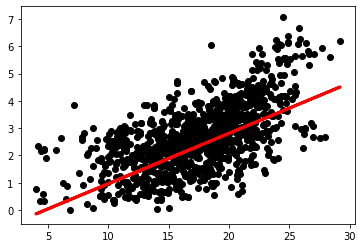

In [11]:
# run sklearn linear regression on the most correlated feature (10kb_negative)
from sklearn.linear_model import LinearRegression

# get rid of all inf and -inf values
bins_train = bins_train[~bins_train.isin([np.nan, np.inf, -np.inf]).any(1)]
bins_val = bins_val[~bins_val.isin([np.nan, np.inf, -np.inf]).any(1)]
bins_test = bins_test[~bins_test.isin([np.nan, np.inf, -np.inf]).any(1)]

bins_train['1kb_combined'] = bins_train['1kb_positive'] - bins_train['1kb_negative']
bins_train['5kb_combined'] = bins_train['5kb_positive'] - bins_train['5kb_negative']
bins_train['10kb_combined'] = bins_train['10kb_positive'] - bins_train['10kb_negative']
bins_train['50kb_combined'] = bins_train['50kb_positive'] - bins_train['50kb_negative']

bins_val['1kb_combined'] = bins_val['1kb_positive'] - bins_val['1kb_negative']
bins_val['5kb_combined'] = bins_val['5kb_positive'] - bins_val['5kb_negative']
bins_val['10kb_combined'] = bins_val['10kb_positive'] - bins_val['10kb_negative']
bins_val['50kb_combined'] = bins_val['50kb_positive'] - bins_val['50kb_negative']

reg = LinearRegression().fit(bins_train['10kb_combined'].values.reshape(-1,1), bins_train['mean_peak_output'].values)
print(reg.score(bins_train['10kb_combined'].values.reshape(-1,1), bins_train['mean_peak_output'].values))

y_val = reg.predict(bins_val['10kb_combined'].values.reshape(-1,1))
print(reg.score(bins_val['10kb_combined'].values.reshape(-1,1), bins_val['mean_peak_output'].values))

plt.scatter(bins_val['10kb_combined'].values.reshape(-1,1), bins_val['mean_peak_output'].values, color='black')
plt.plot(bins_val['10kb_combined'].values.reshape(-1,1), y_val, color='red', linewidth=3)

(0.62320185, 3.441633889549044e-135)


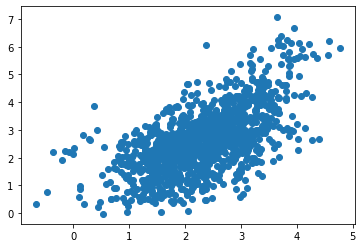

In [9]:
from scipy.stats.stats import pearsonr, spearmanr

y_train = bins_train['mean_peak_output'].to_numpy(dtype=np.float32)
X_train = bins_train.drop(['mean_peak_output'], axis=1).to_numpy(dtype=np.float32)
y_val = bins_val['mean_peak_output'].to_numpy(dtype=np.float32)
X_val = bins_val.drop(['mean_peak_output'], axis=1).to_numpy(dtype=np.float32)
y_test = bins_test['mean_peak_output'].to_numpy(dtype=np.float32)
X_test = bins_test.drop(['mean_peak_output'], axis=1).to_numpy(dtype=np.float32)

reg = LinearRegression().fit(X_train, y_train)

plt.scatter(reg.predict(X_val), y_val)
print(pearsonr(reg.predict(X_val), y_val))

In [52]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam, SGD

model = Sequential([
    Dense(6, input_shape=(8,)),
    Activation('relu'),
    Dense(3),
    Activation('softmax'),
    Dense(1)
])

learning_rate = 1e-3
model.compile(optimizer=Adam(lr=learning_rate),
             loss='mse')

model.fit(X_train, y_train, batch_size=32, nb_epoch=100, verbose=1)

y_pred = model.predict(X_train, batch_size=32)

/users/jjwang01/.conda/envs/proseq/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/100
45106/45106 [==============================] - 2s 54us/step - loss: 2.2735
Epoch 2/100
45106/45106 [==============================] - 2s 45us/step - loss: 1.0958
Epoch 3/100
45106/45106 [==============================] - 2s 46us/step - loss: 0.9435
Epoch 4/100
45106/45106 [==============================] - 2s 35us/step - loss: 0.8941
Epoch 5/100
45106/45106 [==============================] - 1s 30us/step - loss: 0.8821
Epoch 6/100
45106/45106 [==============================] - 1s 33us/step - loss: 0.8768: 0s - loss: 0.
Epoch 7/100
45106/45106 [==============================] - 2s 45us/step - loss: 0.8750
Epoch 8/100
45106/45106 [==============================] - 2s 46us/step - loss: 0.8738
Epoch 9/100
45106/45106 [==============================] - 2s 35us/step - loss: 0.8729
Epoch 10/100
45106/45106 [==============================] - 1s 32us/step - loss: 0.8732
Epoch 11/100
45106/45106 [==============================] - 2s 35us/step - loss: 0.8700
Epoch 12/100
45106/45106 [

45106/45106 [==============================] - 2s 46us/step - loss: 0.8522
Epoch 95/100
45106/45106 [==============================] - 2s 47us/step - loss: 0.8516
Epoch 96/100
45106/45106 [==============================] - 2s 45us/step - loss: 0.8521
Epoch 97/100
45106/45106 [==============================] - 2s 46us/step - loss: 0.8511
Epoch 98/100
45106/45106 [==============================] - 2s 38us/step - loss: 0.8510
Epoch 99/100
45106/45106 [==============================] - 2s 35us/step - loss: 0.8516
Epoch 100/100
45106/45106 [==============================] - 2s 36us/step - loss: 0.8509


In [54]:
from scipy.stats.stats import pearsonr, spearmanr
print(pearsonr(y_train, y_pred.flatten()))
print(spearmanr(y_train, y_pred.flatten()))

y_pred_val = model.predict(X_val, batch_size=1)
print(pearsonr(y_val, y_pred_val.flatten()))
print(spearmanr(y_val, y_pred_val.flatten()))

(0.69392675, 0.0)
SpearmanrResult(correlation=0.6934533481198502, pvalue=0.0)
(0.63134766, 9.379430658953528e-140)
SpearmanrResult(correlation=0.6003150552705686, pvalue=4.627037477290491e-123)


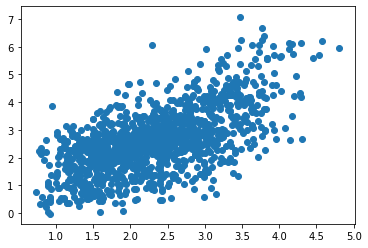

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(x=y_pred_val.flatten(), y=y_val)